<a href="https://colab.research.google.com/github/alvarojd/SolarForecasting/blob/main/LSTM/LSTM_multivariable_Array_MinMax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM NN MULTIVARIABLE**

---


> Red neuronal Long short term memory, entrenada con la variable a predecir, irradiacia global horizontal. Tambien se utilizan diversas variables exogenas disponibles en el dataset

---

**BASE DE DATOS:** KENYA



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---


  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---




En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
ruta='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head(2) # Se muestran las 5 primeras filas del dataframe



---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---



Luego de analizar las corelaciones, se llego a la conclusion de que los datos que más influencia tienen sobre los valores de irradianza `GHI` son los que se seleccionaron y se colocaron en un nuevo dataset:



In [ ]:
#features_considered = ['GHI','Precipitation']#,	'DOY','PST','Precipitation', 'Zenith',	'Humidity'] # Definimos las columnas que se van a utilizar para el entrenamiento del modelo
features_considered = ['ghi_pyr_1','precipitation','relative_humidity','Hour','wind_speed']
features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1,precipitation,relative_humidity,Hour,wind_speed
time,,,,,
2019-12-12 00:00:00,0.0,0.0,99.003998,0,1.073283
2019-12-12 00:15:00,0.0,0.0,98.758003,0,0.727417
2019-12-12 00:30:00,0.0,0.0,98.003998,0,0.415667
2019-12-12 00:45:00,0.0,0.0,96.216003,0,1.380333
2019-12-12 01:00:00,0.0,0.0,97.160004,1,2.620333


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7719241cd0>,
      dtype=object)

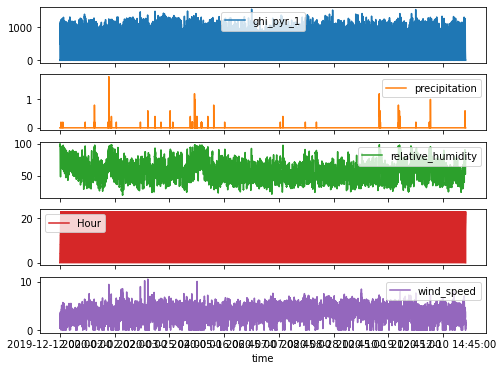

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con una normalización:




---


3_1. **ESCALAMIENTO DE LOS DATOS**


---


In [ ]:
estandar=data['ghi_pyr_1'].values.reshape(len(data),1)
scaler = MinMaxScaler()
dataset = scaler.fit_transform(estandar)

In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
STEP=1
dataset = features.values # Convertimos el dataframe en un arreglo de numpy
data_max = dataset[:TRAIN_SPLIT,0].max(axis=0) # Se obtiene la media estadistica de los datos
#data_std = dataset[:TRAIN_SPLIT,0].std(axis=0) # Se obtiene la desviación estandar de los datos

dataset = (dataset/data_max) #Se normaliza cada dato del arreglo para que todos los valores esten entre -1 y 1





---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS**

--- 

In [ ]:
def ventanas(dataset,xsize,ysize,indexin,indexf):
  #dataset = dataset.T
  n=0
  x=[]
  y=[]
  for i in range(int(((indexf-indexin)/xsize)-1)):
    x.append(dataset[n+indexin:n+indexin+xsize].T)
    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize].T[0])
    n+=xsize
  return np.array(x),np.array(y)


In [ ]:
x_train1,y_train1=ventanas(dataset,96,96,0,TRAIN_SPLIT)
x_val1,y_val1=ventanas(dataset,96,96,308*96,len(dataset))




---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---



La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

Se muestra un ejemplo del gráfico que arroja la función, pero en este caso, no están incluidas predicciones, pero en cuanto se incluyan, se veran en forma de puntos rojos.

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**

---

En las siguientes celdas de texto se va a definir el modelo de ML que se utilizará para realizar las predicciones buscadas, este modelo consta de una capa de entrada, y dos capas intermedias de neuronas tipo LSTM, con una respectiva función de activación.

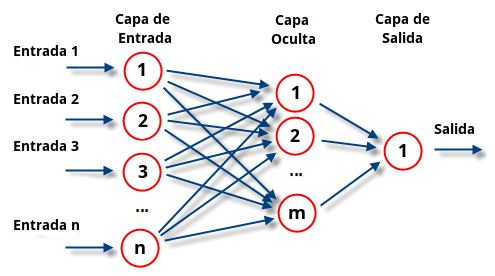

Fig 1. [Perceptrón Multicapa](https://es.wikipedia.org/wiki/Perceptr%C3%B3n_multicapa)

La cantidad de neuronas ajustada de forma manual para maximizar su precisión de entrenamiento y una capa de salida con n neuronas con n datos de predicción buscados.

Además se compila el modelo y dentro de dicha compilación estan incluidas configuraciónes, donde las configuraciones son:

*   **optimizer**: Optimizador utilizado
*   **loss**: Métrica utilizada para determinar las perdidas del modelo
*   **metrics**: Guarda los valores de las metricas en cada epoca de entrenamiento

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.03):
      print("\nReached less than 0.02 losses so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
batch_size=1

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation="tanh", stateful= True, batch_input_shape= (batch_size, x_train1.shape[1], x_train1.shape[2]),  dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, activation="tanh", stateful= True, dropout=0.2),
    tf.keras.layers.Dense(96)
])

model.compile(optimizer='adam', loss='MeanAbsoluteError')# Compilamos el modelo y definimos los ajustes ya explicados

In [ ]:
history = model.fit(x_train1, y_train1, epochs=300, verbose=1, validation_data=(x_val1, y_val1), batch_size=batch_size, shuffle=False, callbacks=[callbacks])


---


# 7. **RESULTADOS** 📃


---


En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

In [ ]:
def metricas(history):
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]


  epochs   = range(1,len(loss)+1,1)
  plt.plot ( epochs,     loss, 'r--', label='Training loss' )
  plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Training and Validation losses'   )
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 

metricas(history)

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  mape= ((y-yt).mean())*100
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mae = abs((y-yt).mean())
  rmse = abs(y-yt).mean()

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mape= ((y-yt).mean())*100
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mae = abs((y-yt).mean())
  rmse = abs(y-yt).mean()

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE,vRMSE))
print("----------------------------------")

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  29.3506      1.5723     48.6944
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  21.0256      0.8715     39.4025
----------------------------------


**CON LOS DATOS DE ENTRENAMIENTO**

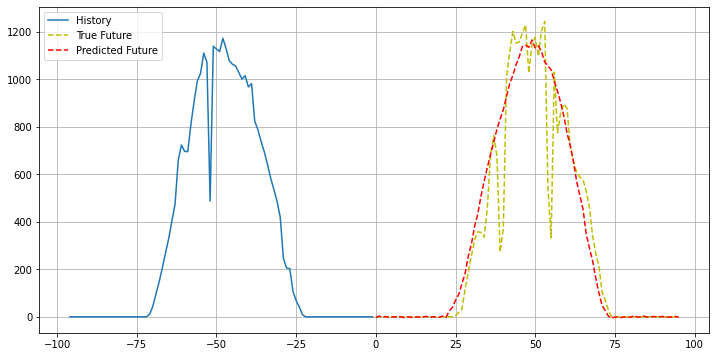

El MAPE para un horizonte de 24h es: 1.1341795553241503 %


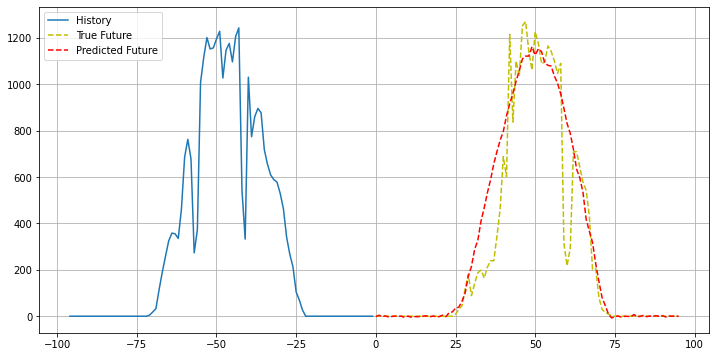

El MAPE para un horizonte de 24h es: 2.5590775489590394 %


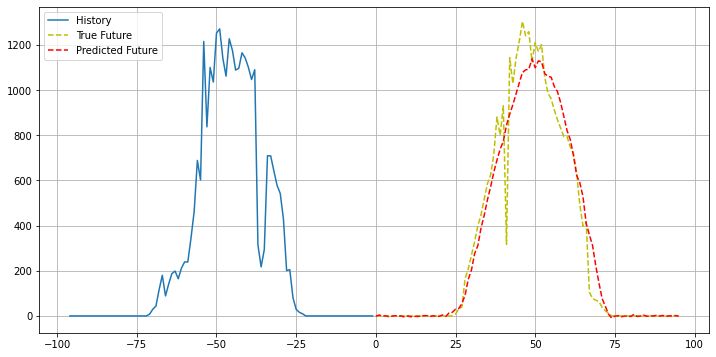

El MAPE para un horizonte de 24h es: 0.19084349706509385 %


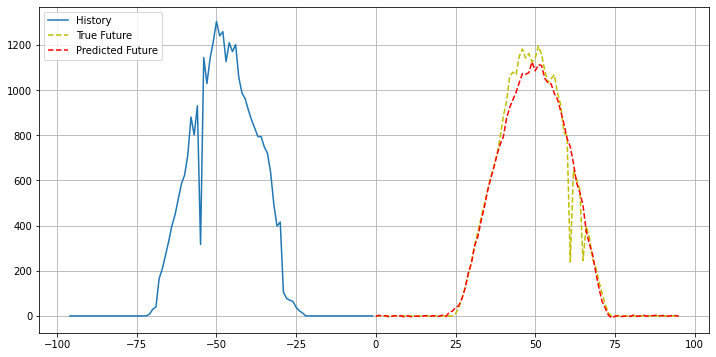

El MAPE para un horizonte de 24h es: 0.45286207679023766 %


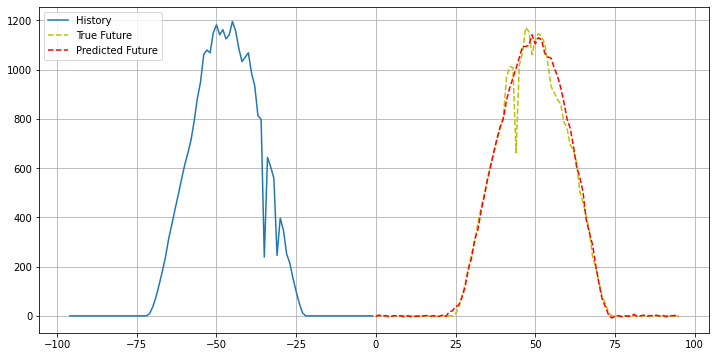

El MAPE para un horizonte de 24h es: 0.4763474540217418 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1

**CON LOS DATOS DE VALIDACIÓN**

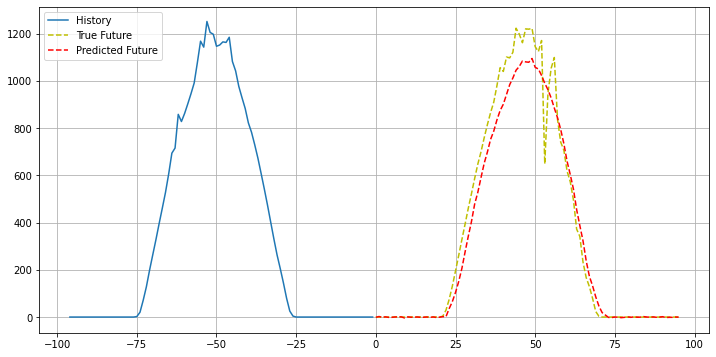

El MAPE para un horizonte de 24h es: 1.9083406139391204 %


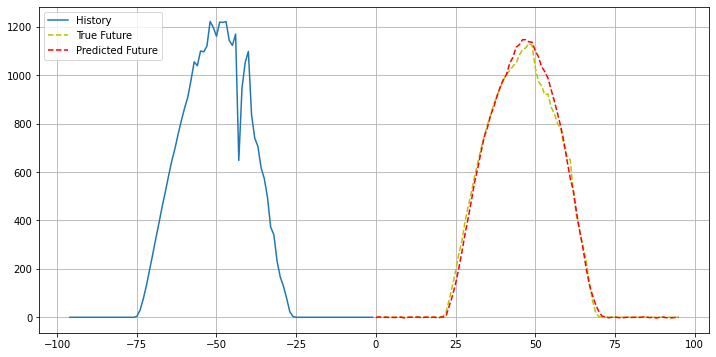

El MAPE para un horizonte de 24h es: 0.24716348677208136 %


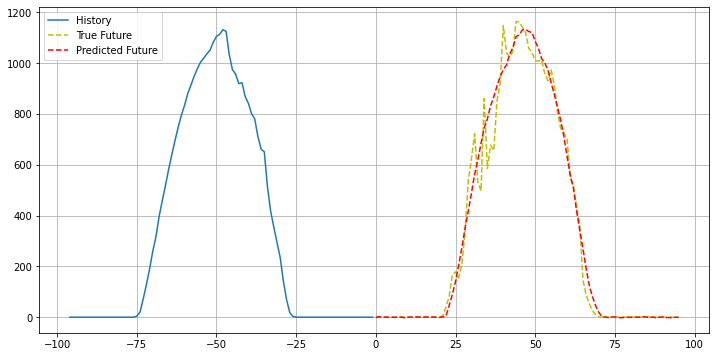

El MAPE para un horizonte de 24h es: 0.42541035400127 %


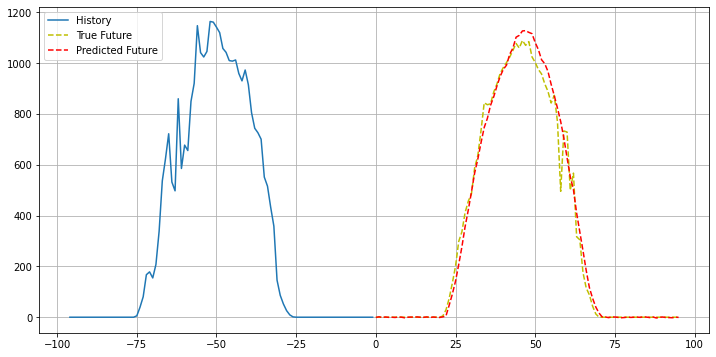

El MAPE para un horizonte de 24h es: 0.4269703946111433 %


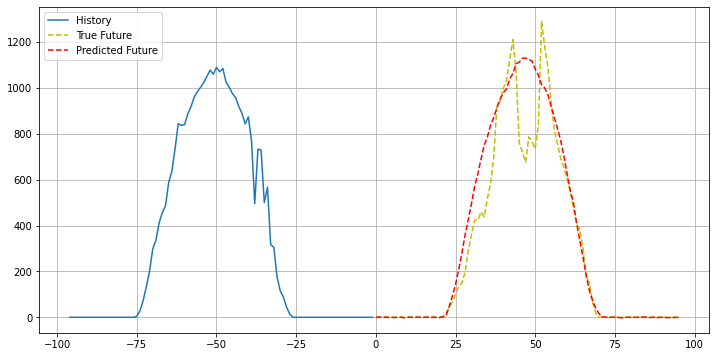

El MAPE para un horizonte de 24h es: 2.7654607576290995 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1